<a href="https://colab.research.google.com/github/sanvika15/Person-Re-Identification/blob/main/MINI_PROJECT_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MINI PROJECT**
## NAME : SANVIKA DAKHALE
## ROLL NO.: 18 - B1

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!pip install kagglehub --quiet
import kagglehub, os

path = kagglehub.dataset_download("pengcw1/market-1501")
print("Dataset Path:", path)
print("Files:", os.listdir(path))


Dataset Path: /kaggle/input/market-1501
Files: ['Market-1501-v15.09.15']


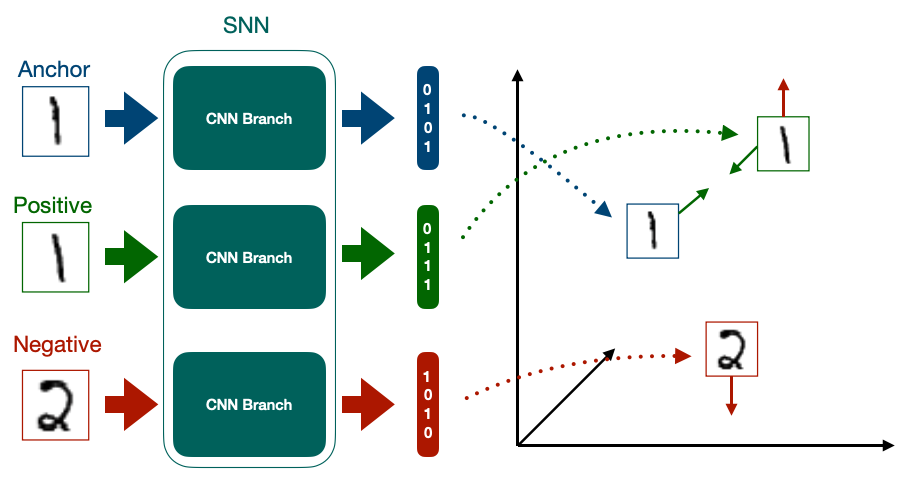

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE = 32
LR = 0.001
EPOCHS =15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)

In [7]:
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [8]:
row = df.iloc[4]

In [9]:
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)


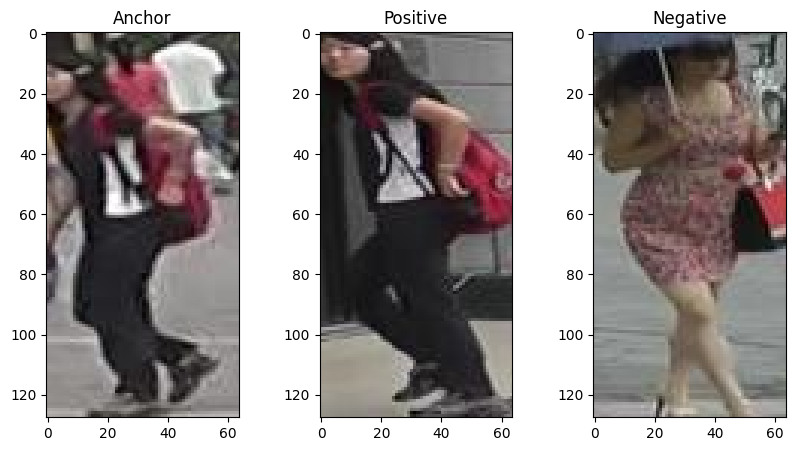

In [10]:
f, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)
ax2.set_title('Positive')
ax2.imshow(P_img)
ax3.set_title('Negative')
ax3.imshow(N_img)

In [11]:
train_df, valid_df = train_test_split(df,test_size=0.20,random_state = 42)

# Create APN Dataset

In [12]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0 ,1)/255.0
    P_img = torch.from_numpy(P_img).permute(2, 0 ,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2, 0 ,1)/255.0

    return A_img, P_img, N_img

In [13]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f'size of trainset: {len(trainset)}')
print(f'size of validset: {len(validset)}')

size of trainset: 3200
size of validset: 800


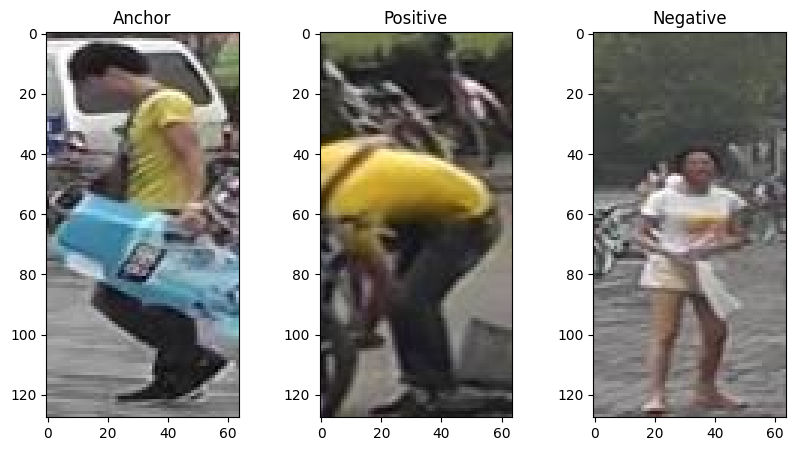

In [14]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [15]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [16]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [17]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [18]:
class APN_Model(nn.Module):
  def __init__(self, emb_size= 512):
    super(APN_Model,self).__init__()

    self.efficientnet = timm.create_model("efficientnet_b0", pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features,out_features=emb_size)

  def forward(self, image):

    embeddings = self.efficientnet(image)

    return embeddings

In [19]:
model = APN_Model()
model.to(DEVICE);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval function

In [20]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [21]:
def valid_fn(model, dataloader, criterion):
  model.eval() #off Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
    return total_loss/len(dataloader)


In [22]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

# Create Training Loop

In [23]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = valid_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("WEIGHT SAVE SUCCESS")

    print(f'EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}')


100%|██████████| 25/25 [00:03<00:00,  8.12it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 1 train_loss : 0.6183978721499443 valid_loss : 0.4008698934316635


100%|██████████| 25/25 [00:03<00:00,  8.21it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 2 train_loss : 0.29428536668419836 valid_loss : 0.32609702527523043


100%|██████████| 25/25 [00:03<00:00,  8.28it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 3 train_loss : 0.19057992056012155 valid_loss : 0.2423780995607376


100%|██████████| 25/25 [00:03<00:00,  8.29it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 4 train_loss : 0.1093345257639885 valid_loss : 0.220112167596817


100%|██████████| 25/25 [00:03<00:00,  8.12it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 5 train_loss : 0.05767055630683899 valid_loss : 0.18408462584018706


100%|██████████| 25/25 [00:03<00:00,  8.22it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 6 train_loss : 0.07259128078818321 valid_loss : 0.15125005841255187


100%|██████████| 25/25 [00:03<00:00,  7.86it/s]


EPOCHS : 7 train_loss : 0.07524500206112862 valid_loss : 0.27192009806632994


100%|██████████| 25/25 [00:03<00:00,  8.20it/s]


EPOCHS : 8 train_loss : 0.06806517153978348 valid_loss : 0.21964966297149657


100%|██████████| 25/25 [00:02<00:00,  8.35it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 9 train_loss : 0.06817952267825604 valid_loss : 0.10668845236301422


100%|██████████| 25/25 [00:03<00:00,  8.19it/s]


EPOCHS : 10 train_loss : 0.0395554569363594 valid_loss : 0.17162226796150207


100%|██████████| 25/25 [00:03<00:00,  8.18it/s]


EPOCHS : 11 train_loss : 0.03825994908809662 valid_loss : 0.13053998351097107


100%|██████████| 25/25 [00:02<00:00,  8.37it/s]


EPOCHS : 12 train_loss : 0.027700783461332323 valid_loss : 0.16457662582397461


100%|██████████| 25/25 [00:03<00:00,  8.25it/s]


EPOCHS : 13 train_loss : 0.020153684616088866 valid_loss : 0.1504499351978302


100%|██████████| 25/25 [00:03<00:00,  8.27it/s]


EPOCHS : 14 train_loss : 0.04202770933508873 valid_loss : 0.16961497485637664


100%|██████████| 25/25 [00:03<00:00,  8.28it/s]

EPOCHS : 15 train_loss : 0.04504986748099327 valid_loss : 0.21391565322875977


# Get Anchor Embeddings

In [24]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []
  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) #(c,h,w)-> (bs,c,h,w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names,encodings],axis = 1)
  return df_enc

In [25]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model,df['Anchor'])

100%|██████████| 4000/4000 [00:47<00:00, 85.07it/s]


In [26]:
df_enc.to_csv('database.csv',index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.938648,0.545712,1.384121,-0.283912,-0.543835,0.234026,0.159126,0.112908,0.427597,...,-1.813460,0.281128,-0.811931,-0.496501,-0.544956,0.329654,0.874347,0.280091,1.020854,1.055108
1,1420_c3s3_061978_03.jpg,-0.791267,0.259649,0.803370,-0.175509,-0.548264,0.404463,0.038104,0.465568,0.294020,...,-1.591422,0.280642,-0.725725,-0.282428,-0.774991,-0.588873,1.313000,0.205089,-0.096193,0.589175
2,1420_c5s3_062565_05.jpg,-1.134046,0.226415,0.936930,-0.290705,-0.909688,0.645001,0.018010,0.601069,0.390483,...,-1.868349,0.228020,-0.759199,-0.492796,-0.577996,-0.340035,0.937658,0.553674,0.871567,0.929651
3,1420_c6s3_085592_04.jpg,-0.808961,0.636941,1.604078,-0.150506,-0.731382,0.239715,0.133611,0.288475,0.279312,...,-1.981585,0.153647,-1.431077,-0.485870,-0.662076,0.101413,1.554854,0.079626,0.481299,1.228119
4,0663_c5s3_085987_03.jpg,0.274852,0.752696,0.446557,0.093005,0.895289,-0.268846,0.511204,-0.397364,0.061778,...,0.399626,0.941312,0.473873,-0.626233,-0.631287,0.944702,-0.866447,-0.486603,0.229738,-0.071160


# Inference

In [27]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr,(img_enc-anc_enc_arr).T))
  return dist

In [28]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR  + img_name


img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()



In [29]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [30]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc,anc_enc_arr[i:i+1,:])
  distance = np.append(distance,dist)

closest_idx = np.argsort(distance)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/layout.py:728: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


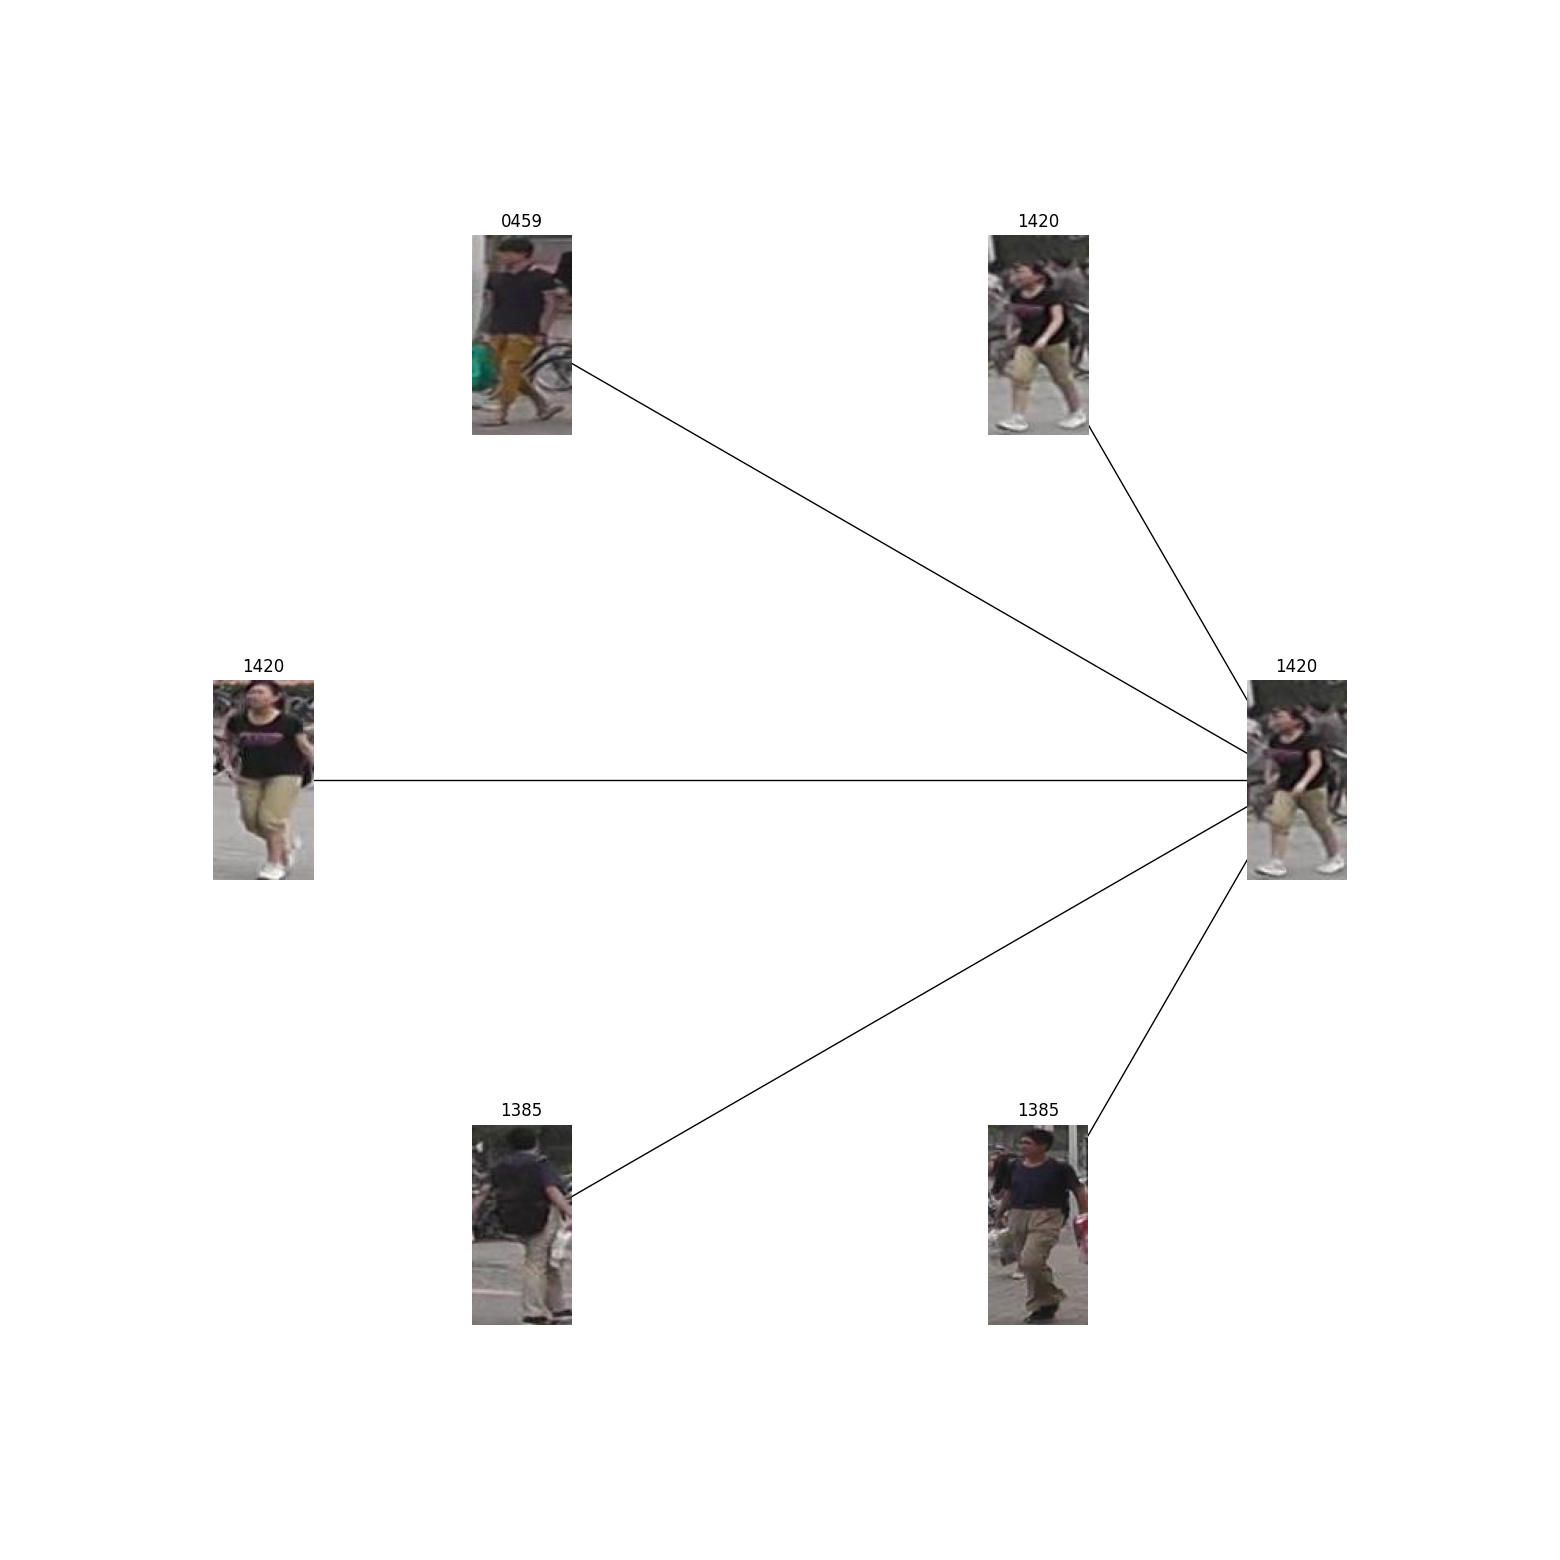

In [31]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);